<a href="https://colab.research.google.com/github/HikariJadeEmpire/THNumber_img_classification/blob/main/numberclassifier.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
#pip install opencv-python

# Choose one (for Cross Validation)
#pip install pycaret
#pip install tune-sklearn ray[tune]

# STEP 1 : Importing

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Importing OpenCV - the computer vision library
import cv2

# import the modules - Directory management
import glob
import os

# SkLearn

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import classification_report 
from sklearn.model_selection import cross_val_score

# STEP 1.1 : SET an important Variables

In [2]:
main_dir = "./Thainumber"

In [3]:
def moveup(img):
    while True:
        if np.all(img[0] >= 240):
            img = img[1:]
        else:
            break
    return img

def movedown(img):
    while True:
        if np.all(img[-1] >= 240):
            img = img[:-1]
        else:
            break
    return img

def moveleft(img):
    while True:
        if np.all(img[:, 0] >= 240):
            img = img[:, 1:]
        else:
            break
    return img

def moveright(img):
    while True:
        if np.all(img[:, -1] >= 240):
            img = img[:, :-1]
        else:
            break
    return img

def rescale(img):
    img = moveup(img)
    img = movedown(img)
    img = moveleft(img)
    img = moveright(img)
    return img

# STEP 2 : Preparing & inspection

In [4]:
file_path_all = list( glob.glob( main_dir + '/**/*.png' ) )

In [5]:
labels = list( map(lambda x: os.path.split( os.path.split(x)[0] )[1] , file_path_all) )

filepath = pd.Series(file_path_all, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

In [6]:
# The following code is utilized for Exploratory Data Analysis (EDA)

data = pd.concat([filepath, labels], axis=1)

data = data.sample(frac=1).reset_index(drop=True)   # Return a random sample of items from an axis of object.
display(data)

print(f'Dataframe shape ( rows x columns ) : {data.shape}')

,Filepath,Label
0,./Thainumber/8/8-10.png,8
1,./Thainumber/4/IMG_0895.png,4
2,./Thainumber/3/3-15.png,3
3,./Thainumber/6/6-29.png,6
4,./Thainumber/2/2-34.png,2
...,...,...
695,./Thainumber/2/IMG_0878.png,2
696,./Thainumber/5/5-33.png,5
697,./Thainumber/8/8-15.png,8
698,./Thainumber/2/IMG_0874.png,2


Dataframe shape ( rows x columns ) : (700, 2)


Prepare for inspections

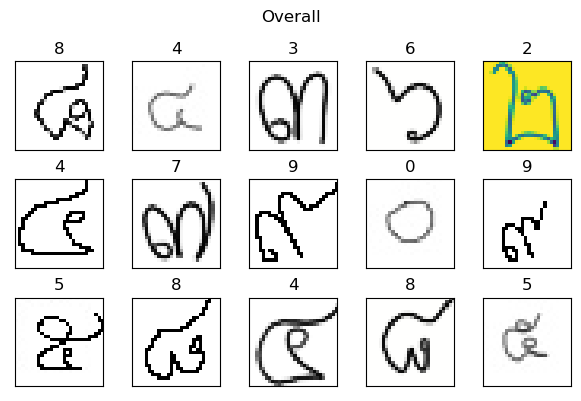

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(6,4), subplot_kw = {'xticks':[],'yticks':[]} )

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
    
fig.suptitle("Overall")
fig.tight_layout()
plt.show()

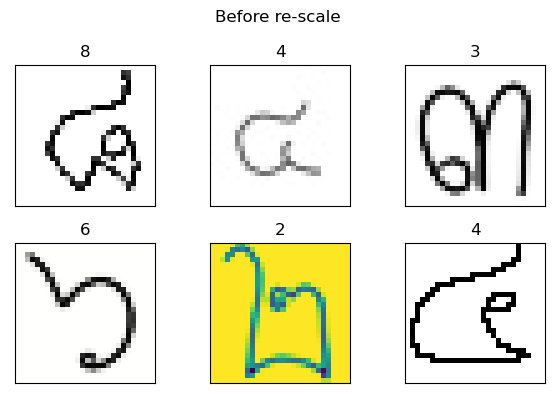

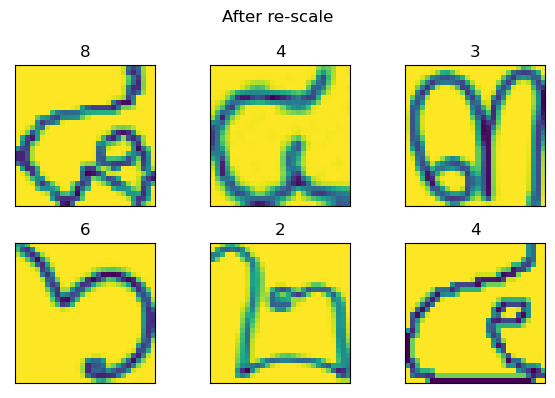

In [8]:
fig1, axes1 = plt.subplots(nrows=2, ncols=3, figsize=(6,4), subplot_kw = {'xticks':[],'yticks':[]} )
fig2, axes2 = plt.subplots(nrows=2, ncols=3, figsize=(6,4), subplot_kw = {'xticks':[],'yticks':[]} )

for i in range(6): # 6 is from nrows*ncolumns in each fig
    
    axes1.flat[i].imshow(plt.imread(data.Filepath[i]))
    axes1.flat[i].set_title(data.Label[i])

    im = cv2.imread(data.Filepath[i])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = rescale(im)
    im = cv2.resize(im, (28, 28))

    axes2.flat[i].imshow(im)
    axes2.flat[i].set_title(data.Label[i])

fig1.suptitle("Before re-scale")
fig1.tight_layout()
#fig1.show()

fig2.suptitle("After re-scale")
fig2.tight_layout()
#fig2.show()

Text(0, 0.5, 'Counts')

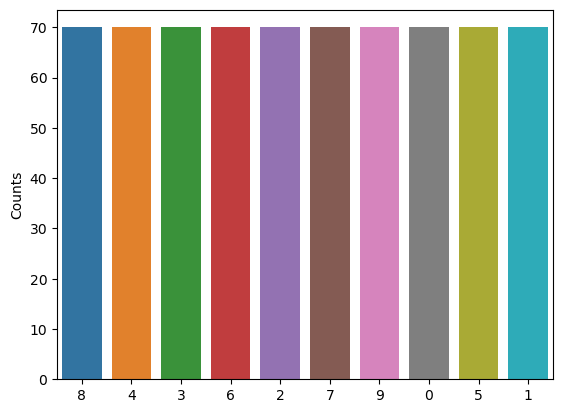

In [9]:
counts = data['Label'].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.ylabel('Counts')

Prepare for Training

In [10]:
# Prepare x , y

change_x = []

for i in data['Filepath'] : # or you can do it directly from 'filepath' and then re-sampling
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = rescale(img)
    img = cv2.resize(img, (28, 28))
    img = img.flatten()
 
    change_x.append(img)

bx = np.asarray(change_x)

x = pd.DataFrame(bx)
y = data['Label']

df = pd.concat( [x, y], axis = 1 )
#df.to_csv('image_df.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,Label
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,155,54,173,230,255,8
1,255,255,255,255,255,255,255,255,255,255,...,254,254,242,227,202,176,148,151,154,4
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,173,96,113,254,3
3,155,131,179,250,255,255,255,255,255,255,...,236,250,255,255,255,255,255,255,255,6
4,255,253,236,209,200,222,243,255,255,255,...,255,255,255,255,255,255,245,239,239,2


In [15]:
# Binarize the output

#y = preprocessing.label_binarize( y , classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] )
#print(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split( x , y , test_size = 0.30, random_state = 42, stratify = y )

# STEP 3 : Train 

<h4>Cross Validation : AutoML </h4>
By : Pycaret

In [17]:
from pycaret.classification import *

s = setup( df, target = 'Label', session_id = 123, train_size = 0.7  )

,Description,Value
0,Session id,123
1,Target,Label
2,Target type,Multiclass
3,Target mapping,"0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9"
4,Original data shape,"(700, 785)"
5,Transformed data shape,"(700, 785)"
6,Transformed train set shape,"(489, 785)"
7,Transformed test set shape,"(211, 785)"
8,Numeric features,784
9,Preprocess,True


In [18]:
best = s.compare_models( sort = 'Accuracy', fold = 5, n_select = 5 )
pull()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9509,0.9984,0.9509,0.9581,0.9508,0.9455,0.9464,2.468
rf,Random Forest Classifier,0.9367,0.9972,0.9367,0.9476,0.9334,0.9296,0.9313,2.504
lightgbm,Light Gradient Boosting Machine,0.9285,0.9954,0.9285,0.9386,0.9274,0.9205,0.9218,3.660
lr,Logistic Regression,0.9182,0.9957,0.9182,0.9334,0.9139,0.9091,0.9115,3.330
svm,SVM - Linear Kernel,0.8937,0.0000,0.8937,0.9115,0.8949,0.8819,0.8841,2.348
knn,K Neighbors Classifier,0.8835,0.9874,0.8835,0.8972,0.8832,0.8705,0.8722,2.844
gbc,Gradient Boosting Classifier,0.8528,0.9841,0.8528,0.8747,0.8525,0.8364,0.8395,13.706
lda,Linear Discriminant Analysis,0.8160,0.9731,0.8160,0.8268,0.8128,0.7955,0.7981,2.402
nb,Naive Bayes,0.7729,0.8974,0.7729,0.8160,0.7711,0.7477,0.7528,2.358
dt,Decision Tree Classifier,0.7546,0.8636,0.7546,0.7687,0.7518,0.7273,0.7296,2.348


In [19]:
display(best)

[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='sqrt',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=-1, oob_score=False,
                        random_state=123, verbose=0, warm_start=False),
 LGBM

In [20]:
model = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9388,0.9970,0.9388,0.9538,0.9369,0.9319,0.9341
1,0.9184,0.9935,0.9184,0.9286,0.9174,0.9092,0.9105
2,0.9796,1.0000,0.9796,0.9830,0.9794,0.9773,0.9778
3,0.9796,0.9993,0.9796,0.9830,0.9794,0.9773,0.9778
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.9592,0.9986,0.9592,0.9660,0.9588,0.9546,0.9555
6,1.0000,0.9995,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9184,0.9965,0.9184,0.9354,0.9171,0.9093,0.9115
8,0.9796,0.9991,0.9796,0.9830,0.9794,0.9773,0.9778


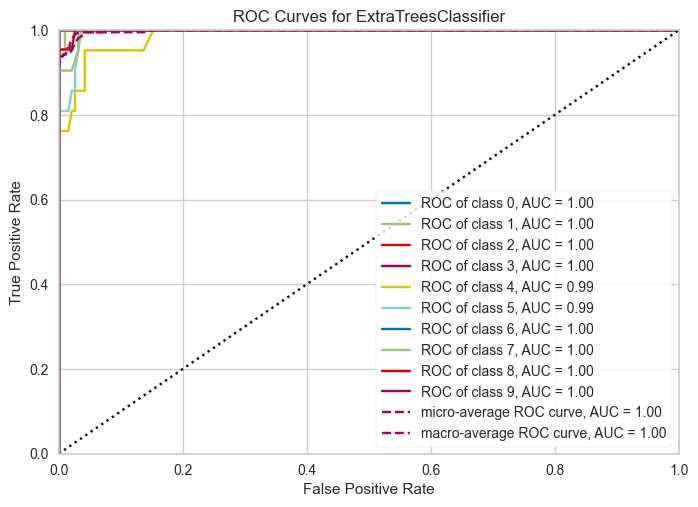

In [21]:
plot_model(model, plot = 'auc')

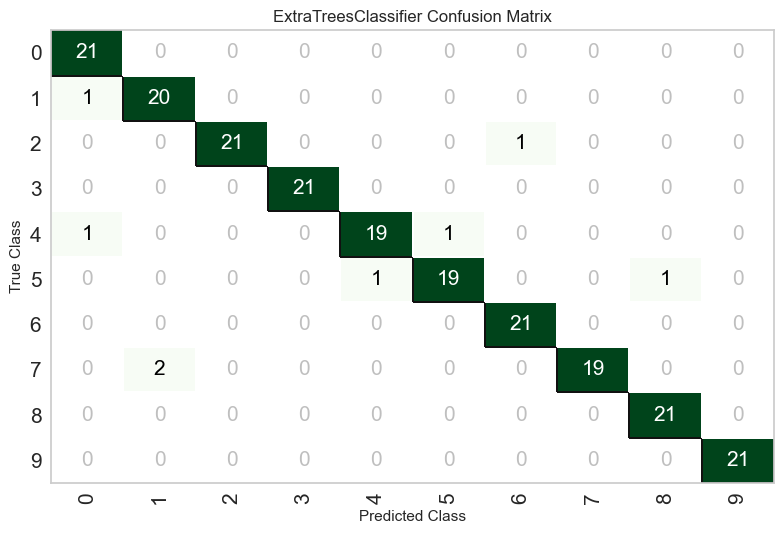

In [22]:
plot_model(model, 'confusion_matrix')

<h4>Pipeline</h4>

In [12]:
steps = [
    ('scalar', MinMaxScaler()),
    ('ExtraTreesClassifier',ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='sqrt',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False))
]

pipeline = Pipeline(steps)

In [13]:
pr = pipeline.fit(X_train, y_train)

# sklearn CV
cv_score = cross_val_score(pr, x, y,
                               cv = 5,
                               scoring = 'accuracy')
print("Mean cross-validation accuracy score:", cv_score.mean())
print("Standard deviation:", cv_score.std())

Mean cross-validation accuracy score: 0.9685714285714285
Standard deviation: 0.009689042833036106


# STEP 4 : Test

In [14]:
y_pred = pr.predict(X_test)

print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       0.95      1.00      0.98        21
           2       1.00      0.95      0.98        21
           3       1.00      1.00      1.00        21
           4       0.86      0.90      0.88        21
           5       0.90      0.90      0.90        21
           6       1.00      1.00      1.00        21
           7       1.00      1.00      1.00        21
           8       1.00      0.95      0.98        21
           9       1.00      1.00      1.00        21

    accuracy                           0.97       210
   macro avg       0.97      0.97      0.97       210
weighted avg       0.97      0.97      0.97       210

